In [4]:
import pandas as pd 
import numpy as np
import calendar
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import osmnx as ox
from folium.plugins import HeatMap
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange,Legend
from bokeh.palettes import Category20
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.resources import CDN
from bokeh.embed import file_html

output_notebook()

Loading BokehJS ...

# Investigation Parking Enforcment Behaviour 

##

In [5]:
df = pd.read_csv("/Users/rasmusblirupjensen/Downloads/Parking_Violations_Issued_-_Fiscal_Year_2019.csv")
codes = pd.read_excel("/Users/rasmusblirupjensen/Downloads/ParkingViolationCodes_Nov_2018.xlsx")



/Users/rasmusblirupjensen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,18,20,22,23,29,30,31,32,36,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#Merging the Data Sets
#Convertin Violation code to integer
codes["VIOLATION CODE"].astype(int)
#df = df.rename(columns={"Violation Code": "Code"})
df_new =  df.merge(codes, left_on="Violation Code",right_on="VIOLATION CODE", how='left')
#Dropping Columns that will not be used
df = df_new.drop(columns=['Plate ID', 'Registration State', 'Plate Type','Street Code1', 'Street Code2', 'Street Code3','Vehicle Expiration Date', 'Time First Observed', 'Intersecting Street', 'Date First Observed', 'Law Section', 'Sub Division', 'Violation Legal Code', 'Days Parking In Effect',
'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color','Unregistered Vehicle?', 'Vehicle Year', 'Meter Number','No Standing or Stopping Violation', 'Hydrant Violation', 'Double Parking Violation',"Violation Description",'Violation In Front Of Or Opposite','Violation Location','Violation County'
], axis=1)

In [7]:
df.head()

,Summons Number,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,House Number,Street Name,Feet From Curb,Violation Post Code,VIOLATION CODE,VIOLATION DESCRIPTION,Manhattan 96th St. & below\n(Fine Amount $),All Other Areas\n(Fine Amount $)
0,1105232165,07/03/2018,14,SDN,HONDA,X,78,968,86684,0968,0,0811P,2,HANSON PLACE,0,NaN,14.0,NO STANDING-DAY/TIME LIMITS,115.0,115.0
1,1121274900,06/28/2018,46,SDN,NISSA,X,112,968,103419,0968,0,1145A,71-30,AUSTIN ST,0,NaN,46.0,DOUBLE PARKING,115.0,115.0
2,1130964875,06/08/2018,24,SUBN,JEEP,X,122,835,0,0835,0,0355P,NaN,GREAT KILLS BOAT LAU,0,NaN,24.0,NO PARKING-EXC. AUTH. VEHICLE,65.0,60.0
3,1130964887,06/07/2018,24,P-U,FORD,X,122,835,0,0835,0,0123P,NaN,GREAT KILLS PARK BOA,0,NaN,24.0,NO PARKING-EXC. AUTH. VEHICLE,65.0,60.0
4,1131599342,06/29/2018,17,SUBN,HYUND,X,78,868,2354,0868,0,0514P,2,HANSON PLACE,0,NaN,17.0,NO STANDING-EXC. AUTH. VEHICLE,95.0,95.0


In [8]:
len(df)

11467506

In [9]:
## converting the Violation Time to datetime 
def time(xx):
    time = []
    for x in xx:
        x = str(x)
        if x[-1:] == "P":
            if x[:2] == "12":
                new_x = "12"
                second = x[2:4]
                new_time = new_x+":"+str(second)+":"+"00"    
                time.append(new_time)
            else:
                first = int(x[:2])+12
                second = x[2:4]
                new_time = str(first)+":"+str(second)+":"+"00"   
                time.append(new_time)
        else:
            if x[:2] == "12":
                new_x = "00"
                second = x[2:4]
                new_time = new_x+":"+str(second)+":"+"00"    
                time.append(new_time)
            else:  
                first = x[:2]
                second = x[2:4]
                new_time = str(first)+":"+str(second)+":"+"00"    
                time.append(new_time)
    return time

In [10]:
%%time
#Converting Date into right format
df['Issue Date']=pd.to_datetime(df["Issue Date"], format='%m/%d/%Y', errors='coerce')
# Creating Time Stamps and time features
df["Day Name"] = df["Issue Date"].apply(lambda x: x.day_name())
df["Day Number"] =  df["Issue Date"].apply(lambda x: x.dayofweek)
df["month"] =  df["Issue Date"].apply(lambda x: x.month)
df["Time"] = time(df['Violation Time'])
df["Time"] = pd.to_datetime(df["Time"], format = '%H:%M:%S',  errors='coerce' )
#df["Time"] = df["Time"].dt.time
df["Hour"] = df["Time"].dt.hour
df.dropna(subset= ["Hour"], inplace = True)
#Dropping Violation code 36 because it is a Speed Camera
df = df[df["VIOLATION DESCRIPTION"] != "PHTO SCHOOL ZN SPEED VIOLATION" ]

CPU times: user 3min 38s, sys: 9.38 s, total: 3min 47s
Wall time: 3min 48s


In [11]:
df.head()

,Summons Number,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,...,Violation Post Code,VIOLATION CODE,VIOLATION DESCRIPTION,Manhattan 96th St. & below\n(Fine Amount $),All Other Areas\n(Fine Amount $),Day Name,Day Number,month,Time,Hour
0,1105232165,2018-07-03,14,SDN,HONDA,X,78,968,86684,0968,...,NaN,14.0,NO STANDING-DAY/TIME LIMITS,115.0,115.0,Tuesday,1,7,1900-01-01 20:11:00,20.0
1,1121274900,2018-06-28,46,SDN,NISSA,X,112,968,103419,0968,...,NaN,46.0,DOUBLE PARKING,115.0,115.0,Thursday,3,6,1900-01-01 11:45:00,11.0
2,1130964875,2018-06-08,24,SUBN,JEEP,X,122,835,0,0835,...,NaN,24.0,NO PARKING-EXC. AUTH. VEHICLE,65.0,60.0,Friday,4,6,1900-01-01 15:55:00,15.0
3,1130964887,2018-06-07,24,P-U,FORD,X,122,835,0,0835,...,NaN,24.0,NO PARKING-EXC. AUTH. VEHICLE,65.0,60.0,Thursday,3,6,1900-01-01 13:23:00,13.0
4,1131599342,2018-06-29,17,SUBN,HYUND,X,78,868,2354,0868,...,NaN,17.0,NO STANDING-EXC. AUTH. VEHICLE,95.0,95.0,Friday,4,6,1900-01-01 17:14:00,17.0


In [ ]:
df.to_csv("parking2019.csv",index=False)

In [ ]:
df.head()

In [ ]:
df.columns


In [ ]:
df.columns

### Information regarding the Dataset

In [11]:
print("Number of Enforcement Commands:", len(df["Issuer Command"].unique()))
print("Number of Enforcement squads:", len(df["Issuer Squad"].unique()))
print("Number of Enforcement guards:", len(df["Issuer Code"].unique()))
print(50*"-")
print("Number of violation districts:", len(df["Violation Precinct"].unique()))


Number of Enforcement Commands: 1096
Number of Enforcement squads: 51
Number of Enforcement guards: 18490
--------------------------------------------------
Number of violation districts: 141


### Top 20 Issuing Guards

In [12]:
print("Top 15 issuers")
print(61*"-")
top_issuer = df["Issuer Command"].value_counts()[:20]
top = top_issuer.index.to_list()
top_issuer

Top 15 issuers
-------------------------------------------------------------


T103    260305
T302    213359
T401    199370
T201    194553
T402    184265
T301    161453
T106    108640
T102    106310
T105     85130
T101     74079
MTTF     43625
T303     28350
0401     26881
T802     19800
T801     17772
T800     14293
T803     11140
T108     10028
T501      7856
T730      4108
Name: Issuer Command, dtype: int64

In [13]:
#for i in top:
#    fine = df.loc[df["Issuer Command"] == i]
#    a = fine["Date"].dt.day.value_counts()
#    b = a.sort_index()
#    c = b.to_list()
#    d = b.index.to_list()
#    plt.bar(d, c)
#    plt.title(i)
#    plt.show()

In [15]:
#Top 5 most violtated parkings crimes
topfines = df["VIOLATION DESCRIPTION"].value_counts()[:10]
topfines

NO PARKING-STREET CLEANING        360036
FAIL TO DSPLY MUNI METER RECPT    233993
NO STANDING-DAY/TIME LIMITS       202008
NO PARKING-DAY/TIME LIMITS        159222
DOUBLE PARKING                    118305
FIRE HYDRANT                      111289
INSP. STICKER-EXPIRED/MISSING     109919
EXPIRED MUNI METER                 96722
FAILURE TO STOP AT RED LIGHT       94587
REG. STICKER-EXPIRED/MISSING       63533
Name: VIOLATION DESCRIPTION, dtype: int64

In [50]:
fines = topfines.index.to_list()
df = result.loc[result['VIOLATION DESCRIPTION'].isin(fines)]

In [52]:
#Length and number of variables in the dataset 
print("Number of rows: {}  \nNumber of Variables: {}" .format(df.shape[0], str(df.shape[1])))

Number of rows: 1705427  
Number of Variables: 52


In [53]:
df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Double Parking Violation,Date,Day Name,Day Number,month,VIOLATION DESCRIPTION,Manhattan 96th St. & below\n(Fine Amount $),All Other Areas\n(Fine Amount $),Time,Hour
0,8693880032,T756209C,NY,OMT,01/28/2019,38,4DSD,CHRYS,T,40930,...,NaN,2019-01-28,Monday,0,1,FAIL TO DSPLY MUNI METER RECPT,65.0,35.0,1900-01-01 15:56:00,15.0
1,8671121859,HYS3655,NY,PAS,11/18/2018,20,SUBN,HONDA,T,24440,...,NaN,2018-11-18,Sunday,6,11,NO PARKING-DAY/TIME LIMITS,65.0,60.0,1900-01-01 00:38:00,0.0
3,8603126227,GEV5230,NY,PAS,08/01/2018,46,2DSD,MINI,T,22240,...,NaN,2018-08-01,Wednesday,2,8,DOUBLE PARKING,115.0,115.0,1900-01-01 13:58:00,13.0
4,5103223648,L83CED,NJ,PAS,09/04/2018,7,WAGO,CHEVR,V,0,...,NaN,2018-09-04,Tuesday,1,9,FAILURE TO STOP AT RED LIGHT,50.0,50.0,1900-01-01 06:30:00,6.0
6,5105308037,HKB7715,NY,PAS,02/15/2019,7,4DSD,TOYOT,V,0,...,NaN,2019-02-15,Friday,4,2,FAILURE TO STOP AT RED LIGHT,50.0,50.0,1900-01-01 14:37:00,14.0


In [85]:
df["VIOLATION DESCRIPTION"].unique()
len(df.loc[df["VIOLATION DESCRIPTION"]=='PHTO SCHOOL ZN SPEED VIOLATION']["Issuer Squad"])

219155

In [54]:
import plotly.graph_objects as go
from ipywidgets import widgets

In [60]:
month = widgets.IntSlider(
    value=1.0,
    min=1.0,
    max=12.0,
    step=1.0,
    description='Month:',
    continuous_update=False
)

use_date = widgets.Checkbox(
    description='Date: ',
    value=True,
)

container = widgets.HBox(children=[use_date, month])


origin = widgets.Dropdown(
    options=list(df['VIOLATION DESCRIPTION'].unique()),
    value='FAIL TO DSPLY MUNI METER RECPT',
    description='Violation:',
)


# Assign an empty figure widget with two traces
trace1 = go.Histogram(x=df['Hour'], opacity=0.75, name='Issuer Command')
#trace2 = go.Histogram(x=df['dep_delay'], opacity=0.75, name='Departure Delays')
g = go.FigureWidget(data=[trace1],
                    layout=go.Layout(
                        title=dict(
                            text='NYC FlightDatabase'
                        ),
                        barmode='overlay'
                    ))

In [67]:
def validate():

    if origin.value in df['VIOLATION DESCRIPTION'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        if use_date.value:
            filter_list = [i and j and k for i, j, k in
                           zip(df['month'] == month.value,
                               df['VIOLATION DESCRIPTION'] == origin.value)]
            temp_df = df[filter_list]

        else:
            filter_list = [i and j for i, j in
                           zip( df['VIOLATION DESCRIPTION'] == origin.value)]
            temp_df = df[filter_list]
        x1 = temp_df['Issuer Command']
        
        with g.batch_update():
            g.data[0].x = x1
            g.data[1].x = x2
            g.layout.barmode = 'overlay'
            g.layout.xaxis.title = 'Delay in Minutes'
            g.layout.yaxis.title = 'Number of Delays'


origin.observe(response, names="value")
#textbox.observe(response, names="value")
month.observe(response, names="value")
use_date.observe(response, names="value")

In [71]:
container2 = widgets.HBox([origin])
widgets.VBox([container,
              g])

In [16]:
def bokeh(df,x):
    bokeh = df[df["VIOLATION DESCRIPTION"].isin(fines)] #Reducing the dataframe only to obtain the forcuscrimes
    station = bokeh.groupby(df[x])["VIOLATION DESCRIPTION"].value_counts().unstack()
    station.reset_index(level=0, inplace=True) # creating a new index, so hour becomes a column. 
    
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    source = ColumnDataSource(station)
    
    hours = [] # empty list to store the string converted hours
    for i in range(len(df[x].unique())):
        hours.append(str(i))
    
    p = figure(x_range = FactorRange(factors=hours),plot_height=500, plot_width= 1200, toolbar_location=None, title="Distibution of # of fines for top 10 violations pr. {}".format(x))
    bar ={}
    items = [] 
    for indx,i in enumerate(fines):
        bar[i] = p.vbar(x=x, width=0.5,  top=i, source = source, muted_alpha =0.09, alpha=3, muted_color=Category20[15][indx] ,color=Category20[15][indx]) 
        items.append((i, [bar[i]])) #the dictionary is appended to the items list, to the respective category.  
        
    legend = Legend(items=items, location=(0,50)) #Legend and location is configured
    p.add_layout(legend, "left") #Adding the legend outisde the plot. 
    p.xaxis.axis_label = x #Setting x-axis title
    p.yaxis.axis_label = "# of fines" #Setting y-axis title
    p.x_range.range_padding = 0.04 # 
    p.legend.click_policy="mute" #mute is chossen, becuase this enables one to see all of the different categories partily if not chosen, instead of hiding them. 
    show(p) 

In [73]:
bokeh(df,"Hour")
bokeh(df,"month")
bokeh(df, "Day Number")

In [26]:
import plotly.io as pio
pio.write_html(fig, file='index.html', auto_open=True)


ValueError: 
The fig parameter must be a dict or Figure.
    Received value of type <class 'NoneType'>: None

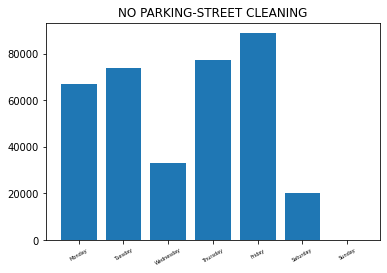

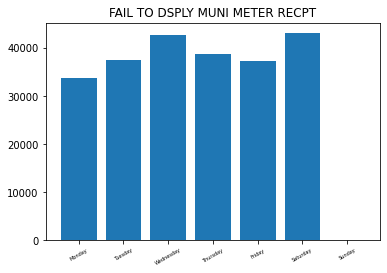

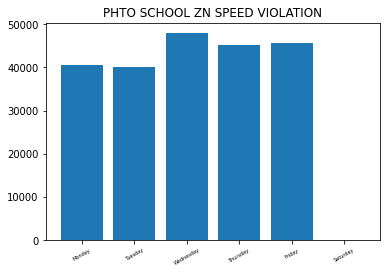

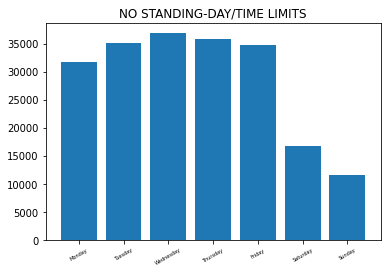

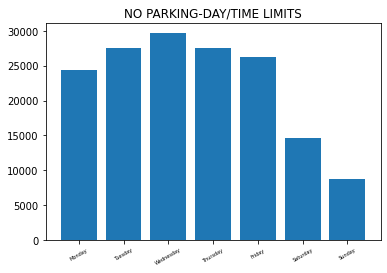

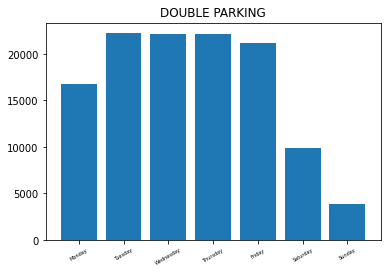

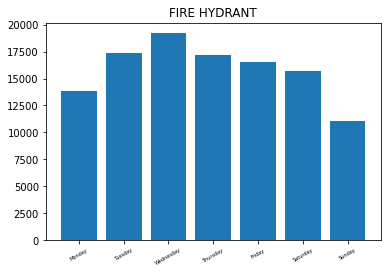

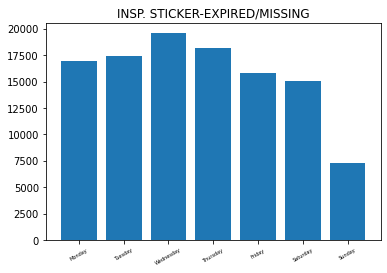

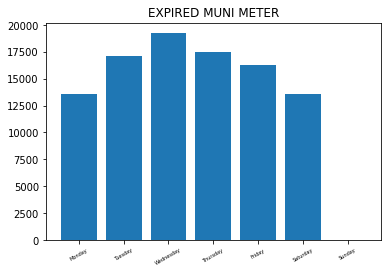

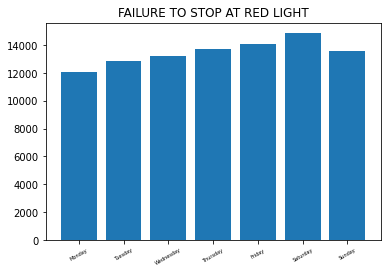

In [405]:
for i in fines:
    fine = df.loc[df["VIOLATION DESCRIPTION"] == i]
    days = dict(zip(fine["Day Number"], fine["Day Name"]))
    count_weekdays = fine["Day Number"].value_counts()
    count_weekdays = count_weekdays.sort_index()
    days_count = count_weekdays.to_list()
    days_num = count_weekdays.index.to_list()
    day_name = list(map(days.get,days_num))
    plt.bar(days_num, days_count)
    plt.title(i)
    plt.xticks(days_num, day_name, fontsize=5, rotation=30)
    plt.show()

In [ ]:
for i in fines:
    fine = df.loc[df["VIOLATION DESCRIPTION"] == i]
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    count_months = fine["Month Number"].value_counts()
    count_weekdays = count_months.sort_index()
    month_count = count_months.to_list()
    month_num = count_months.index.to_list()
    month_name = list(map(monthDict.get,month_num))
    plt.bar(month_num, month_count)
    plt.title(i)
    plt.xticks(month_num, month_name, fontsize=5, rotation=30)
    plt.show()

#Data Properties 
In the dataset, there is geolocation attributes, such as strees names, house numbers, states codes etc. Next there is description of the different vehicles. There is an issue date which tells us when the violation has happened, and a timestamp for the violation. 

In [73]:
#result.shape
#result["Adress"] = result["Street Name"] + " " + str(result["House Number"])

In [17]:
#result_new.to_csv("PARKING2019.csv")

In [75]:
#result.columns

In [25]:
a= "0918A"

In [39]:
result_new['Issuer Squad'].unique()

array([nan, 'N', 'A', 'J', 'F', 'B', 'D', 'T', 'S', 'L', 'W', 0.0, 'Q',
       'C', '0000', 'V', 'K', 'I', 'G', 'X', 'H', 'E', 'Y', 'M', 'R', 'O',
       'EE', 'AA', 'P', 'B2', 'FF', 'DD', 'HH', 'CC', 'A2', 'GG', 'BB',
       'U', 'YA', 'II', 'X1', 'YP', 'X2', 'D2', 'GA', 'Z', 'AB', 'FA',
       'GP', 'C2', 'A1'], dtype=object)